In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import h5py
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
import _spin_params as spin_pars
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes
#%qtconsole

In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr;
kappa = np.pi*fr/quali #HWHM
delta = spin_pars.delta #detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac #detuning drive to cavity wc-wp
gperp = spin_pars.gperp #HWHM
gpar = spin_pars.gpar#0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins#701#5000#20
nbins = spin_pars.nbins
g_number = spin_pars.g_number #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

4.174817177486928


In [3]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)

x_start = 5
x_stop = 20 #µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

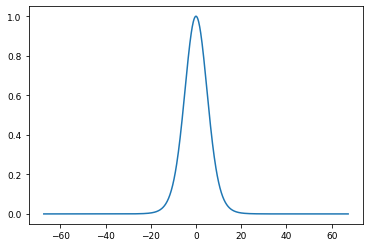

In [4]:
spins, gs, pdf = create_spins_inhomo_g(gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.plot(spins[:len(pdf)], pdf/max(pdf))

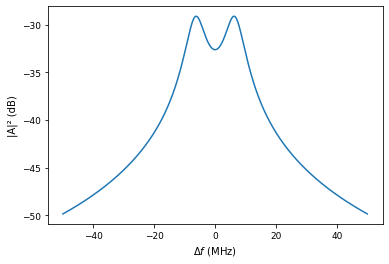

In [5]:
initsteady = (0.001,0.001)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

### Calibrate power

In [6]:
pumptime = 100e-3#5*np.pi/gcoll
decaytime = 2000e-3
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0


In [7]:
pulsei = np.ones((len(tlist)))
pin = np.arange(-35, -20,0.5)
aref = 4000

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

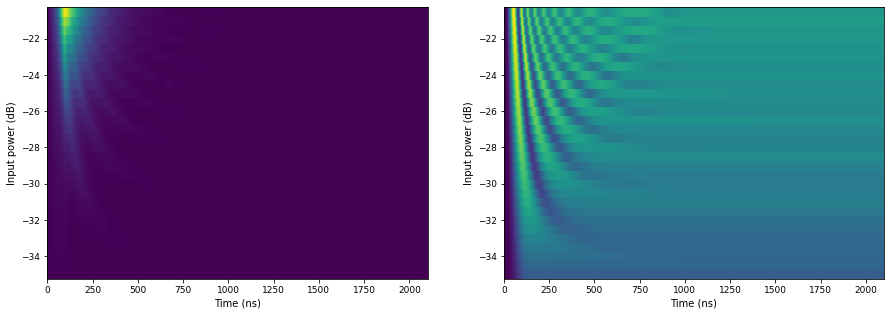

In [8]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.pcolor(tplot, pin, alos, shading="auto")
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos, shading="auto")
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');
maxAmpl = abs(asolpump).max()

# SOC pulses

In [11]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

tlist = np.arange(0, 0.504, dt)

fcomps = np.array([-1.177,  1.646, -0.549, -1.668, -0.627,  0.151,  1.68 , -0.024,
        0.858,  1.311, -0.15 , -0.355,  0.253,  1.165,  0.069,  0.47 ,
       -0.649, -0.814,  0.643, -0.657])
wgrund = 2*np.pi
nfreqs = int(len(fcomps)/2)

ilist = pulse_rwa(tlist, (wgrund, fcomps[:nfreqs]))
qlist = pulse_rwa(tlist, (wgrund, fcomps[nfreqs:]))


#temporary

ilist = np.array([  926.20205324,   996.35384028,  1016.16157642,   980.25742907,
         885.69625847,   732.12715862,   522.10650674,   261.53873747,
         -39.98960339,  -369.32407515,  -710.52820471, -1046.28723955,
       -1359.61830527, -1635.47278713, -1861.87555451, -2030.37776516,
       -2135.76079516, -2175.1378865 , -2146.87586959, -2049.98268509,
       -1884.53068748, -1653.15164977, -1362.87599496, -1026.1664236 ,
        -660.33201285,  -285.40389903,    78.6695572 ,   414.5006031 ,
         708.82558212,   953.12342697,  1143.58899815,  1280.78478628,
        1369.13863469,  1416.28614027,  1432.18204865,  1427.956546  ,
        1414.62231278,  1401.85289796,  1397.06656916,  1404.94747841,
        1427.38159551,  1463.67120448,  1510.86904049,  1564.12731501,
        1617.03553785,  1661.97793642,  1690.55949015,  1694.13547585,
        1664.44902387,  1594.34797887,  1478.52411822,  1314.1982427 ,
        1101.66654963,   844.62985495,   550.24907256,   228.90631129,
        -106.3081129 ,  -440.32894588,  -757.00253115, -1040.06843591,
       -1274.20106236, -1446.09383639, -1545.56079639, -1566.58332864,
       -1508.14902521, -1374.647549  , -1175.57599823,  -924.4369303 ,
        -637.00081757,  -329.43337386,   -16.93573362,   286.66164171,
         568.40956062,   815.4024276 ,  1014.29616645,  1151.63335263,
        1214.97172444,  1194.44901612,  1084.30515589,   883.98962864,
         598.6758467 ,   239.1729691 ,  -178.67576334,  -634.98244678,
       -1107.06561122, -1570.85084822, -2002.32394199, -2378.94791856,
       -2680.95484698, -2892.4173611 , -3002.00787164, -3003.38348789,
       -2895.20141845, -2680.85653366, -2368.09364633, -1968.63281951,
       -1497.84821977,  -974.41468838,  -419.76654552,   142.75129869,
         689.04587789,  1195.64137689,  1641.07790085,  2007.18613717,
        2280.12948017,  2451.15387557,  2517.01312742,  2480.05005415,
        2347.92400586,  2132.99911812,  1851.44049212,  1522.09916228,
        1165.2852144 ,   801.52718574,   450.39910259,   129.47429085,
        -146.55333005,  -366.55136151,  -523.41121655,  -614.27213373,
        -640.49613966,  -607.3953517 ,  -523.7294919 ,  -401.00842764,
        -252.64881792,   -93.04291472])
qlist = np.array([  158.97003496,  -306.22810099,  -756.05325355, -1163.01649073,
       -1502.14146785, -1752.32282482, -1897.40274739, -1926.9176465 ,
       -1836.53328941, -1628.22081988, -1310.20789228,  -896.68966928,
        -407.24841535,   134.06613741,   700.00821695,  1261.72770321,
        1790.60208957,  2260.16217708,  2647.87571692,  2936.48813003,
        3114.66710046,  3176.90891759,  3122.95192816,  2957.10544892,
        2687.79937969,  2327.36576603,  1891.81277055,  1400.31620856,
         874.3103312 ,   336.25730246,  -191.71103014,  -689.08334215,
       -1138.06278979, -1524.41754594, -1838.0957156 , -2073.62411748,
       -2230.28534653, -2312.03223212, -2327.08679322, -2287.19974536,
       -2206.60708828, -2100.78165743, -1985.11231754, -1873.64274486,
       -1777.9757855 , -1706.41482563, -1663.38369062, -1649.14519793,
       -1659.82384785, -1687.72654964, -1721.94310614, -1749.19396547,
       -1754.87592491, -1724.23802735, -1643.6032308 , -1501.54035819,
       -1289.89189327, -1004.57753353,  -646.11983952,  -219.86770865,
         264.08194523,   791.25187446,  1343.42964993,  1899.58530174,
        2437.05588409,  2932.96680408,  3365.79868353,  3716.92380226,
        3971.8742486 ,  4121.12949741,  4160.3517678 ,  4090.19624222,
        3915.9541844 ,  3647.25556387,  3297.88521389,  2885.58082124,
        2431.60460349,  1959.94239   ,  1496.11835874,  1065.7342268 ,
         692.90126751,   398.73395663,   200.04137503,   108.31048672,
         129.03687741,   261.42746826,   498.47788324,   827.41380061,
        1230.47656697,  1686.02057981,  2169.86227873,  2656.77582939,
        3121.98277579,  3542.46404409,  3897.96391436,  4171.65565755,
        4350.55012159,  4425.78263067,  4392.87551872,  4251.97473554,
        4007.97202556,  3670.40299889,  3253.05574227,  2773.29263468,
        2251.13766211,  1708.19869551,  1166.49034327,   647.22137467,
         169.62070621,  -250.10656614,  -599.59557153,  -870.83143071,
       -1060.31650399, -1168.91159826, -1201.40984557, -1165.9209968 ,
       -1073.14063234,  -935.5604566 ,  -766.65692462,  -580.08433654,
        -388.89976395,  -204.85637582,   -37.81144535,   104.70514144,
         217.72921309,   298.89729687])

ilist *= 1/max(max(abs(ilist)), max(abs(qlist)))
qlist *= 1/max(max(abs(ilist)), max(abs(qlist)))

In [12]:
pin_det = np.arange(-35, 10,0.5)


alos_soc = np.zeros((len(pin_det), len(tlist)+len(tlistdecay)))
szlos_soc = np.zeros(np.shape(alos_soc))
szall_soc = np.zeros((len(pin_det), len(tlist)+len(tlistdecay), nbins))
small_soc = np.zeros(np.shape(szall_soc))
smlos_soc = np.zeros(np.shape(alos_soc))


detuning = -20
deltac_det = 2*np.pi*((-1)*detuning)


for ctr, p in enumerate(pin_det):
    dr = aref*10**(p/20.)
    ipulse = ilist*dr;
    qpulse = qlist*dr;
    asolpump, asoldecay, infodict = solve_mbes(mbes_soc, init, pdf, tlist, tlistdecay, ipulse, qpulse, tlist, kappa, deltac_det, gs, gperp, spins+detuning, gpar)
    alos_soc[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos_soc[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall_soc[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small_soc[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos_soc[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

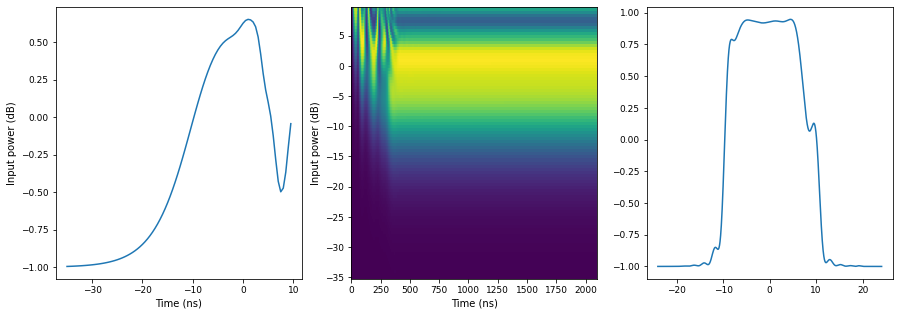

In [44]:
idealidx = int(np.where( szlos_soc[:, -1]==max( szlos_soc[:, -1]))[0])

tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(pin_det, szlos_soc[:, -1])
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');
ax2.pcolor(tplot, pin_det, szlos_soc, shading="auto")
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');
ax3.plot(spins, szall_soc[idealidx, -1, :]/pdf)
maxAmpl = abs(asolpump).max()